# Previously we have considered how to work with Time Series data by ARIMA and ML techniques
# Here and now we are going to find connections and create approach to predict Q2 values depending on pumps, sprinkles and HE fouling effects

# Classification problem

In [1]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels

In [137]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import (
    TimeSeriesSplit, cross_validate, 
    KFold, train_test_split,
    ShuffleSplit
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import tree

from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from joblib import dump, load

In [3]:
# this are periods when 1,2,3,4 HEs were under operation
time_periods = [
    ("2022-09-05","2022-09-09"), ("2022-09-12","2022-09-13"),
    ("2022-10-17","2022-10-21"), ("2022-11-08","2022-11-11"), ("2022-11-15","2022-11-18"),
    ("2022-11-22","2022-11-25"), ("2022-11-29","2022-12-02"), ("2022-12-05","2022-12-09"), 
    ("2022-12-12","2022-12-16"), ("2022-12-19","2022-12-23"), ("2023-01-10","2023-01-13"), 
    ("2023-01-16","2023-01-19"), ("2023-01-24","2023-01-27"), ("2023-01-31","2023-02-03"), 
    ("2023-02-07","2023-02-09"), ("2023-02-13","2023-02-17"), ("2023-02-28","2023-03-03"), 
    ("2023-03-06","2023-03-07"), ("2023-03-09","2023-03-10"), ("2023-03-14","2023-03-17"),
    ("2023-03-27","2023-03-31"), ("2023-04-03","2023-04-07"), ("2023-04-10","2023-04-14"),
#     ("2023-04-17","2023-04-21"), ("2023-05-02","2023-05-05"), ("2023-05-08","2023-05-12"),
#     ("2023-05-15","2023-05-19"), ("2023-05-22","2023-05-26"), ("2023-05-29","2023-06-02"),
#     ("2023-06-05","2023-06-09"),
]

time_periods2 = [
    ("2021-09-06","2021-09-10"), ("2021-09-13","2021-09-17"), ("2021-09-20","2021-10-01"),
    ("2021-10-04","2021-10-08"), ("2021-10-11","2021-10-15"), ("2021-11-08","2021-11-12"),
    ("2021-11-15","2021-11-19"), ("2021-11-22","2021-11-26"), ("2021-11-29","2021-12-03"),
    ("2021-12-07","2021-12-03"), ("2021-12-13","2021-12-17"), ("2021-12-20","2021-12-24"),
    ("2022-01-18","2022-01-21"), ("2022-01-24","2022-01-26"), ("2022-02-01","2022-02-04"),
    ("2022-02-08","2022-02-11"), ("2022-02-14","2022-02-18"), ("2022-02-24","2022-02-25"),
    ("2022-03-01","2022-03-04"), ("2022-03-15","2022-03-18"), ("2022-03-21","2022-03-25"),
    ("2022-03-29","2022-04-01"), ("2022-04-12","2022-04-15"), ("2022-04-18","2022-04-22"),
    ("2022-05-02","2022-05-06"), ("2022-05-09","2022-05-13"), ("2022-05-16","2022-05-20"),
    ("2022-05-23","2022-05-27"), ("2022-06-07","2022-06-10"), ("2022-06-20","2022-06-24"),
    ("2022-06-28","2022-07-01"),
    
]

time_periods3 = [
    ("2020-10-12","2020-10-16"), ("2020-10-21","2020-10-23"), ("2020-10-28","2020-10-30"),
    ("2020-11-11","2020-11-13"), ("2020-11-16","2020-11-20"), ("2020-11-24","2020-11-27"),
    ("2020-12-03","2020-12-04"), ("2020-12-07","2020-12-11"), ("2020-12-16","2020-12-18"), 
    ("2020-12-24","2020-12-25"), ("2020-12-29","2020-12-30"), ("2021-01-12","2021-01-15"),
    ("2021-01-18","2021-01-22"), ("2021-02-01","2021-02-05"), ("2021-02-08","2021-02-12"),
    ("2021-02-15","2021-02-19"), ("2021-03-01","2021-03-05"), ("2021-03-09","2021-03-12"),
    ("2021-03-15","2021-03-19"), ("2021-03-22","2021-03-26"), ("2021-04-01","2021-04-02"),
    ("2021-04-05","2021-04-09"), ("2021-04-05","2021-04-09"), ("2021-04-12","2021-04-16"),
    ("2021-04-20","2021-04-24"), ("2021-04-26","2021-04-30"), ("2021-05-03","2021-05-07"),
    ("2021-05-11","2021-05-15"), ("2021-05-17","2021-05-21"), ("2021-05-24","2021-05-28"),
    ("2021-06-15","2021-06-18"), ("2021-06-21","2021-06-25"), ("2021-06-28","2021-07-02"),
]

In [4]:
# fc 119,120,121
fcs = [
    ("2021-03-09", "2021-04-12"), ("2021-04-12", "2021-05-11"), ("2021-05-11", "2021-09-20")
]

In [5]:
time_periods_all = [*time_periods3, *time_periods2, *time_periods]

### All IDs used
* 299 Т1к после ТО
* 309 Р2контура
* 315 T1k before HE
* 317 Т2к перед ТО
* 319 Т2к после ТО
* 321 T reactor
* 325 Т2к выхТО1
* 327 Твозвуха
* 381 Iвг1
* 395 Iвг2
* 396 Iвг3
* 460 Т2к выхТО2
* 461 Т2к выхТО3
* 462 Т2к выхТО4
* 463 Т2к выхТО5
* 480 Q1k
* 481 Q2контура
#### Second loop I pumps id
* 406 2-1
* 407 2-2
* 408 2-3
* 409 2-4

In [6]:
sys.path.insert(0, os.path.split(os.path.abspath(""))[0])
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))

In [7]:
from preprocessing import CsvRefactorer
from analytics import WaterFlowRates
from statistics import Statistics as st
from data_engineering import PeriodicDataPreprocess, FeatureEngineering
from statistics import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima import model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, ccf

In [14]:
# 60 min frequency

df_stats = pd.read_excel("!important_input_files/rdy_for_stats_121020_090623_1h_freq.xlsx", index_col="Timestamp")

# The idea is to make n-number of bins (averaging data while bining)

In [15]:
df_stats["Q2"].describe()

count    5880.000000
mean      751.115247
std       119.717394
min       516.212917
25%       659.713229
50%       732.366042
75%       846.692604
max      1062.355417
Name: Q2, dtype: float64

In [84]:
Q2_bins = np.arange(500,1100, 20)
Q2_labels = np.arange(0, len(Q2_bins)-1, 1)
len(Q2_bins),Q2_bins, Q2_labels

(30,
 array([ 500,  520,  540,  560,  580,  600,  620,  640,  660,  680,  700,
         720,  740,  760,  780,  800,  820,  840,  860,  880,  900,  920,
         940,  960,  980, 1000, 1020, 1040, 1060, 1080]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]))

In [32]:

df_stats["Q2_bins"] = pd.cut(df_stats["Q2"], bins=Q2_bins, labels=Q2_labels)

<AxesSubplot: xlabel='Timestamp', ylabel='HE4_TOP'>

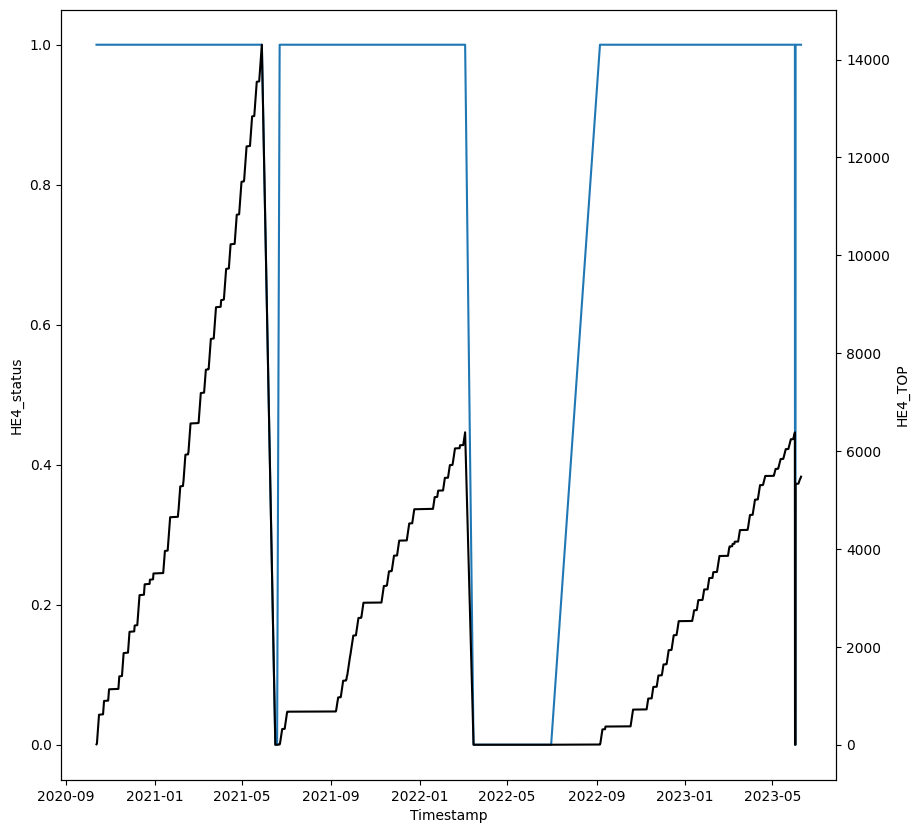

In [201]:
fig, ax = plt.subplots(figsize=(10,10))
ax1 = ax.twinx()
sns.lineplot(df_stats["HE4_status"], ax=ax)
sns.lineplot(df_stats["HE4_TOP"], ax=ax1, color="black")


<AxesSubplot: xlabel='Q2', ylabel='Count'>

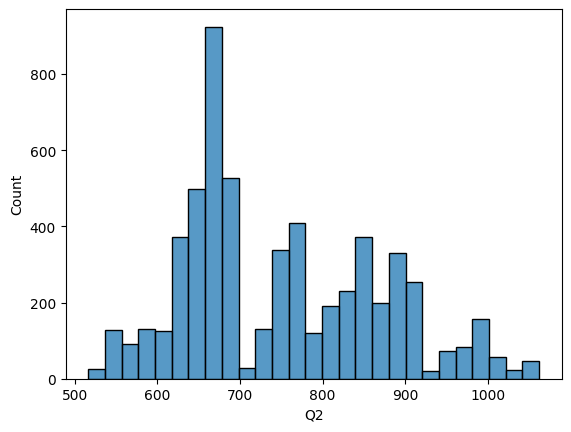

In [36]:
sns.histplot(df_stats["Q2"])

In [37]:
from statsmodels.api import qqplot

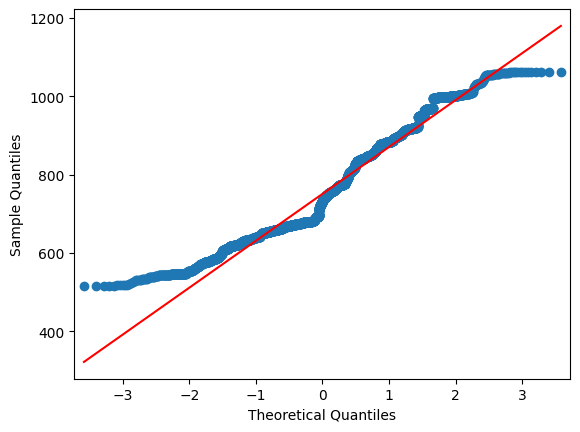

In [38]:
qqplot(df_stats["Q2"].to_numpy(), line ='s')
plt.show()

In [39]:
# df_stats = df_stats.loc["2021-04":, :]
df_stats.shape

(5880, 36)

In [40]:
df_stats["HEs_num"] = df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)
df_stats["Q2_HEs_num"] = df_stats["Q2"] / df_stats["HEs_num"]
df_stats["QbyIP_HEs_num"] = df_stats["QbyIP"] / df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)


In [41]:
df_stats.columns

Index(['P2', 'Q2', 'T1aHE', 'T1bHE', 'T2aHE', 'T2aHE1', 'T2aHE2', 'T2aHE3',
       'T2aHE4', 'T2aHE5', 'T2bHE', 'Tair', 'Treactor', 'p21', 'p22', 'p23',
       'p24', 'dt1', 'dt2', 'pumps2', 'dt_circuits_coef',
       'dt_circuits_coef_delta', 'I2mean', 'QbyIP', 'HE1_TOP', 'HE2_TOP',
       'HE3_TOP', 'HE4_TOP', 'HE5_TOP', 'HE1_status', 'HE2_status',
       'HE3_status', 'HE4_status', 'HE5_status', 'HE_TOP_mean', 'Q2_bins',
       'HEs_num', 'Q2_HEs_num', 'QbyIP_HEs_num'],
      dtype='object')

In [44]:
fe = FeatureEngineering(df_stats)

In [45]:
nozzles_periods = [
    ("2020-10-12", "2021-07-02"), 
    ("2021-09-06", "2023-06-09")
]
df_stats = fe.make_time_onpower_feature(
    time_periods=nozzles_periods,
    feature_name="Nozzles_TOP"
)

[3.32210526e+00 6.64421053e+00 9.96631579e+00 ... 6.30535579e+03
 6.30867789e+03 6.31200000e+03] 1900 1900
[3.86532663e+00 7.73065327e+00 1.15959799e+01 ... 1.53762693e+04
 1.53801347e+04 1.53840000e+04] 3980 3980


In [51]:
selection_cols_Q2 = [
        "Q2_bins", "I2mean", "Nozzles_TOP", 
        "pumps2",
        "HE1_TOP",
        "HE2_TOP",
        "HE3_TOP",
        "HE4_TOP",
        "HE5_TOP",
        "HE1_status",
        "HE2_status",
        "HE4_status", 
        "HE5_status",
        "HE3_status"
    ]

In [52]:
df_stats_Q2 = df_stats.loc[
    :, 
    selection_cols_Q2
]

In [53]:
numerical_cols = [
    "Nozzles_TOP", "I2mean", 
    "HE1_TOP",
    "HE2_TOP",
    "HE3_TOP",
    "HE4_TOP",
    "HE5_TOP",
]
ct = ColumnTransformer(
        [
            ("numerical_data", StandardScaler(), numerical_cols),
            ("categorical_data", OneHotEncoder(sparse=False), ["pumps2"])
        ],
        remainder="passthrough"
).set_output(transform="pandas")

In [56]:
X = df_stats_Q2.drop(["Q2_bins"], axis=1)
y = df_stats_Q2["Q2_bins"]

In [57]:
X.shape, y.shape

((5880, 13), (5880,))

In [60]:
X_ct = ct.fit_transform(X)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_ct, y, test_size=0.3)

In [143]:
knc = KNeighborsClassifier()
lr = LogisticRegression()
dtc = tree.DecisionTreeClassifier()

In [144]:
knc.fit(X_train, y_train)
lr.fit(X_train, y_train)
dtc.fit(X_train, y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DecisionTreeClassifier()

In [149]:
y_pred_knc = knc.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_dtc = dtc.predict(X_test)

In [150]:
from sklearn.metrics import f1_score, roc_auc_score

In [151]:
f1_score(y_test, y_pred_knc, average="macro"), f1_score(y_test, y_pred_dtc, average="macro") 

(0.8917189963147151, 0.9495560455552798)

<AxesSubplot: xlabel='Q2_bins', ylabel='Count'>

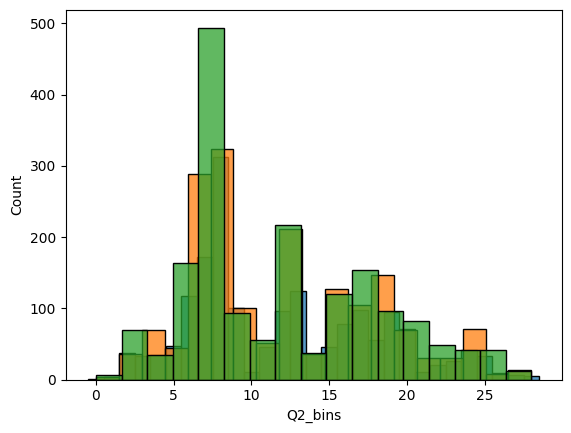

In [154]:
sns.histplot(y_test)
sns.histplot(y_pred_knc)
sns.histplot(y_pred_dtc)

In [193]:
d = {
        "Nozzles_TOP" : 0,
        "I2mean" : 145,
        "pumps2" : 234,
        "HE1_TOP" : 50,
        "HE2_TOP" : 50,
        "HE3_TOP" : 50,
        "HE4_TOP" : 5000,
        "HE5_TOP" : 900,
        "HE1_status": 1,
        "HE2_status": 1,
        "HE3_status": 1,
        "HE4_status": 0,
        "HE5_status": 1,
    
}

In [194]:
inp2 = pd.DataFrame(
    d,
    index=[0]
)

In [195]:
inp2 = ct.transform(inp2)

In [196]:
Q2_bins[knc.predict(inp2)], Q2_bins[knc.predict(inp2)+1]

(array([940]), array([960]))

In [191]:
Q2_bins[knc.predict(inp)], Q2_bins[knc.predict(inp)+1]

(array([1040]), array([1060]))

In [192]:
Q2_bins[dtc.predict(inp)], Q2_bins[dtc.predict(inp)+1]

(array([1040]), array([1060]))

# Upload new data

In [108]:
df_new = pd.read_csv("050923_2nd_circuit.csv")

In [109]:
prep_csv = CsvRefactorer(df_new)

In [110]:
ids = prep_csv.select_by_ids(prep_csv.ids)

In [111]:
group = prep_csv.min_frac_groupby(30, *ids)

In [112]:
df_new = prep_csv.concat_dfs(group)

In [113]:
df_new = df_new.rename(columns=prep_csv.IDS_MAP)

<AxesSubplot: xlabel='Timestamp', ylabel='Q2'>

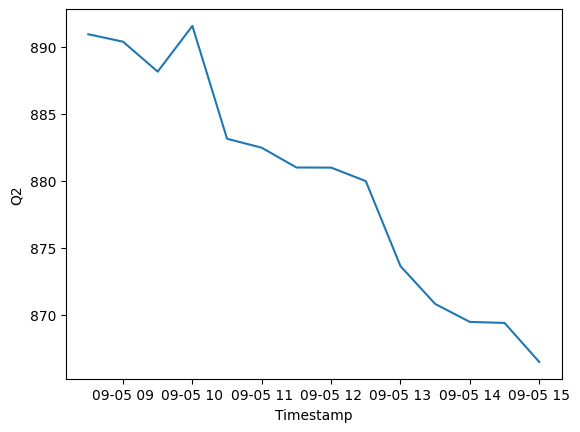

In [114]:
sns.lineplot(df_new["Q2"])

In [115]:
# df_new_to_test = df_new.loc[:, ["P2", "Q2", "p21", "p22", "p23", "p24"]]

In [116]:
fe_new = FeatureEngineering(df_new)

In [117]:
fe_new.filter_by_zscore(column="Q2")

Q2


,T1aHE,P2,T1bHE,T2bHE,T2aHE,Treactor,T2aHE1,Tair,p21,p22,p23,p24,T2aHE2,T2aHE3,T2aHE4,T2aHE5,Q2,dt_circuits_coef,dt_circuits_coef_delta
Timestamp,,,,,,,,,,,,,,,,,,,
2023-09-05 08:30:00,40.857692,0.400500,45.739240,29.450725,33.471429,41.472500,33.902941,14.294805,0.030766,142.866758,141.162499,145.436935,33.804569,33.323688,20.480788,33.188289,890.937500,1.553077,16.288516
2023-09-05 09:00:00,42.760377,0.400000,47.804630,30.761321,34.989524,43.528448,35.437736,14.805932,0.000000,142.313542,140.986958,145.366919,35.325088,34.830422,20.767632,34.659338,890.383333,1.554050,17.043309
2023-09-05 09:30:00,44.708824,0.400000,50.825234,30.137383,35.317476,46.410811,35.880392,16.256780,1.580323,140.533770,140.814034,145.134092,35.674484,35.046645,21.141995,34.830231,888.150000,1.686451,20.687851
2023-09-05 10:00:00,44.691579,0.397742,51.141237,28.885148,34.395049,46.616964,35.042308,18.641176,0.993253,140.078531,140.851415,144.971821,34.875031,34.106728,21.538133,33.907264,891.558333,1.770503,22.256089
2023-09-05 10:30:00,44.404124,0.400000,50.890323,28.426804,34.031959,46.295575,34.672165,19.441025,0.084533,139.724615,140.274349,144.481389,34.514845,33.717110,21.927713,33.515870,883.141667,1.790223,22.463519
2023-09-05 11:00:00,44.048913,0.400000,50.553124,28.015958,33.619565,46.068965,34.274000,19.788793,0.125866,139.576859,140.169986,144.348741,34.104442,33.305605,22.299481,33.119063,882.475000,1.804440,22.537167
2023-09-05 11:30:00,43.831868,0.400000,50.324731,27.845454,33.431960,46.026956,34.108420,20.681897,1.112286,140.307453,140.377763,144.432700,33.922976,33.123702,22.662904,32.936687,881.000000,1.807287,22.479277
2023-09-05 12:00:00,43.759341,0.400000,50.274193,27.721783,33.332653,45.949107,34.005941,19.661865,2.016971,141.189984,141.065094,144.898816,33.837617,33.027879,23.010739,32.831859,880.991667,1.813527,22.552411
2023-09-05 12:30:00,43.692392,0.400000,50.246392,27.672728,33.298936,45.965218,33.964706,18.866957,0.000000,140.267759,140.711494,144.495301,33.798407,32.976974,23.338704,32.779034,879.983333,1.815737,22.573664


In [118]:
fe_new.df = fe_new.df.rolling(6).mean().dropna()

In [119]:
fe_new.df["pumps2"] = np.full(shape=len(fe_new.df), fill_value=234)

In [120]:
fe_new.columns_averaging(columns=["p21", "p22", "p23", "p24"], omitbelow=50, feature_name="I2mean")

['p21', 'p22', 'p23', 'p24']


,T1aHE,P2,T1bHE,T2bHE,T2aHE,Treactor,T2aHE1,Tair,p21,p22,...,p24,T2aHE2,T2aHE3,T2aHE4,T2aHE5,Q2,dt_circuits_coef,dt_circuits_coef_delta,pumps2,I2mean
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-05 11:00:00,43.578585,0.399707,49.492298,29.279556,34.304167,45.065544,34.868257,17.204752,0.469123,140.849012,...,144.956649,34.716410,34.055033,21.359290,33.870009,887.774306,1.693124,20.212742,234,142.171845
2023-09-05 11:30:00,44.074281,0.399624,50.256546,29.012011,34.297589,45.824620,34.902503,18.269267,0.649377,140.422461,...,144.789277,34.736144,34.021702,21.722976,33.828075,886.118056,1.735492,21.244535,234,141.930274
2023-09-05 12:00:00,44.240775,0.399624,50.668140,28.505422,34.021444,46.228063,34.663871,19.078589,0.985539,140.235202,...,144.711260,34.488233,33.721278,22.096827,33.523496,884.552778,1.778739,22.162719,234,141.846189
2023-09-05 12:30:00,44.071369,0.399624,50.571667,28.094646,33.685020,46.153798,34.344590,19.513619,0.722151,140.190867,...,144.604795,34.175553,33.376333,22.462946,33.181629,883.191667,1.800286,22.477021,234,141.790226
2023-09-05 13:00:00,43.893382,0.400000,50.411352,27.882858,33.496783,46.034731,34.161558,19.696842,0.821382,140.274709,...,144.516281,33.992433,33.182534,22.815881,32.986833,880.205556,1.808059,22.528494,234,141.689721
2023-09-05 13:30:00,43.753867,0.400000,50.289414,27.724611,33.350152,45.967672,34.024176,19.610694,1.398526,140.360858,...,144.489077,33.855053,33.036583,23.155478,32.838937,878.152778,1.813932,22.564803,234,141.576106
2023-09-05 14:00:00,43.660389,0.400000,50.210780,27.621600,33.261075,45.935824,33.942771,19.615512,1.377548,140.434662,...,144.453791,33.773751,32.945442,23.480046,32.743155,875.987500,1.817846,22.589179,234,141.455115
2023-09-05 14:30:00,43.598918,0.400000,50.164991,27.551653,33.205024,45.902452,33.893086,19.444930,1.793840,140.426042,...,144.428662,33.726311,32.887349,23.790821,32.679966,874.055556,1.820786,22.613337,234,141.306623
2023-09-05 15:00:00,43.553863,0.400000,50.135958,27.494622,33.163684,45.886290,33.858762,19.521227,2.011168,140.266457,...,144.328661,33.694472,32.843628,24.088756,32.631337,871.640278,1.823503,22.641337,234,141.037547


In [122]:
st = 0

period = [("2023-09-04", "2023-09-05")]

fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE1_TOP", start=st
)

fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE2_TOP", start=st
)

fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE3_TOP", start=st
)

fe_new.df["HE4_TOP"] = np.zeros(len(fe_new.df))


fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="HE5_TOP", start=(912+st)
)

[ 2.66666667  5.33333333  8.         10.66666667 13.33333333 16.
 18.66666667 21.33333333 24.        ] 9 9
[ 2.66666667  5.33333333  8.         10.66666667 13.33333333 16.
 18.66666667 21.33333333 24.        ] 9 9
[ 2.66666667  5.33333333  8.         10.66666667 13.33333333 16.
 18.66666667 21.33333333 24.        ] 9 9
[914.66666667 917.33333333 920.         922.66666667 925.33333333
 928.         930.66666667 933.33333333 936.        ] 9 9


,T1aHE,P2,T1bHE,T2bHE,T2aHE,Treactor,T2aHE1,Tair,p21,p22,...,Q2,dt_circuits_coef,dt_circuits_coef_delta,pumps2,I2mean,HE1_TOP,HE2_TOP,HE3_TOP,HE4_TOP,HE5_TOP
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-05 11:00:00,43.578585,0.399707,49.492298,29.279556,34.304167,45.065544,34.868257,17.204752,0.469123,140.849012,...,887.774306,1.693124,20.212742,234,142.171845,2.666667,2.666667,2.666667,0.0,914.666667
2023-09-05 11:30:00,44.074281,0.399624,50.256546,29.012011,34.297589,45.824620,34.902503,18.269267,0.649377,140.422461,...,886.118056,1.735492,21.244535,234,141.930274,5.333333,5.333333,5.333333,0.0,917.333333
2023-09-05 12:00:00,44.240775,0.399624,50.668140,28.505422,34.021444,46.228063,34.663871,19.078589,0.985539,140.235202,...,884.552778,1.778739,22.162719,234,141.846189,8.000000,8.000000,8.000000,0.0,920.000000
2023-09-05 12:30:00,44.071369,0.399624,50.571667,28.094646,33.685020,46.153798,34.344590,19.513619,0.722151,140.190867,...,883.191667,1.800286,22.477021,234,141.790226,10.666667,10.666667,10.666667,0.0,922.666667
2023-09-05 13:00:00,43.893382,0.400000,50.411352,27.882858,33.496783,46.034731,34.161558,19.696842,0.821382,140.274709,...,880.205556,1.808059,22.528494,234,141.689721,13.333333,13.333333,13.333333,0.0,925.333333
2023-09-05 13:30:00,43.753867,0.400000,50.289414,27.724611,33.350152,45.967672,34.024176,19.610694,1.398526,140.360858,...,878.152778,1.813932,22.564803,234,141.576106,16.000000,16.000000,16.000000,0.0,928.000000
2023-09-05 14:00:00,43.660389,0.400000,50.210780,27.621600,33.261075,45.935824,33.942771,19.615512,1.377548,140.434662,...,875.987500,1.817846,22.589179,234,141.455115,18.666667,18.666667,18.666667,0.0,930.666667
2023-09-05 14:30:00,43.598918,0.400000,50.164991,27.551653,33.205024,45.902452,33.893086,19.444930,1.793840,140.426042,...,874.055556,1.820786,22.613337,234,141.306623,21.333333,21.333333,21.333333,0.0,933.333333
2023-09-05 15:00:00,43.553863,0.400000,50.135958,27.494622,33.163684,45.886290,33.858762,19.521227,2.011168,140.266457,...,871.640278,1.823503,22.641337,234,141.037547,24.000000,24.000000,24.000000,0.0,936.000000


In [123]:
fe_new.make_time_onpower_feature(
    time_periods=period, feature_name="Nozzles_TOP", start=0
)

[ 2.66666667  5.33333333  8.         10.66666667 13.33333333 16.
 18.66666667 21.33333333 24.        ] 9 9


,T1aHE,P2,T1bHE,T2bHE,T2aHE,Treactor,T2aHE1,Tair,p21,p22,...,dt_circuits_coef,dt_circuits_coef_delta,pumps2,I2mean,HE1_TOP,HE2_TOP,HE3_TOP,HE4_TOP,HE5_TOP,Nozzles_TOP
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-05 11:00:00,43.578585,0.399707,49.492298,29.279556,34.304167,45.065544,34.868257,17.204752,0.469123,140.849012,...,1.693124,20.212742,234,142.171845,2.666667,2.666667,2.666667,0.0,914.666667,2.666667
2023-09-05 11:30:00,44.074281,0.399624,50.256546,29.012011,34.297589,45.824620,34.902503,18.269267,0.649377,140.422461,...,1.735492,21.244535,234,141.930274,5.333333,5.333333,5.333333,0.0,917.333333,5.333333
2023-09-05 12:00:00,44.240775,0.399624,50.668140,28.505422,34.021444,46.228063,34.663871,19.078589,0.985539,140.235202,...,1.778739,22.162719,234,141.846189,8.000000,8.000000,8.000000,0.0,920.000000,8.000000
2023-09-05 12:30:00,44.071369,0.399624,50.571667,28.094646,33.685020,46.153798,34.344590,19.513619,0.722151,140.190867,...,1.800286,22.477021,234,141.790226,10.666667,10.666667,10.666667,0.0,922.666667,10.666667
2023-09-05 13:00:00,43.893382,0.400000,50.411352,27.882858,33.496783,46.034731,34.161558,19.696842,0.821382,140.274709,...,1.808059,22.528494,234,141.689721,13.333333,13.333333,13.333333,0.0,925.333333,13.333333
2023-09-05 13:30:00,43.753867,0.400000,50.289414,27.724611,33.350152,45.967672,34.024176,19.610694,1.398526,140.360858,...,1.813932,22.564803,234,141.576106,16.000000,16.000000,16.000000,0.0,928.000000,16.000000
2023-09-05 14:00:00,43.660389,0.400000,50.210780,27.621600,33.261075,45.935824,33.942771,19.615512,1.377548,140.434662,...,1.817846,22.589179,234,141.455115,18.666667,18.666667,18.666667,0.0,930.666667,18.666667
2023-09-05 14:30:00,43.598918,0.400000,50.164991,27.551653,33.205024,45.902452,33.893086,19.444930,1.793840,140.426042,...,1.820786,22.613337,234,141.306623,21.333333,21.333333,21.333333,0.0,933.333333,21.333333
2023-09-05 15:00:00,43.553863,0.400000,50.135958,27.494622,33.163684,45.886290,33.858762,19.521227,2.011168,140.266457,...,1.823503,22.641337,234,141.037547,24.000000,24.000000,24.000000,0.0,936.000000,24.000000


In [125]:
fe_new.df["HE1_status"] = np.zeros(len(fe_new.df))
fe_new.df["HE2_status"] = np.zeros(len(fe_new.df))
fe_new.df["HE3_status"] = np.zeros(len(fe_new.df))
fe_new.df["HE4_status"] = np.zeros(len(fe_new.df))
fe_new.df["HE5_status"] = np.zeros(len(fe_new.df))

In [126]:
fe_new.df.loc[:, "HE1_status"][fe_new.df.loc[:, "HE1_TOP"] != 0] = 1

fe_new.df.loc[:, "HE2_status"][fe_new.df.loc[:, "HE2_TOP"] != 0] = 1

fe_new.df.loc[:, "HE3_status"][fe_new.df.loc[:, "HE3_TOP"] != 0] = 1

fe_new.df.loc[:, "HE4_status"][fe_new.df.loc[:, "HE4_TOP"] != 0] = 1

fe_new.df.loc[:, "HE5_status"][fe_new.df.loc[:, "HE5_TOP"] != 0] = 1

/tmp/ipykernel_4184/1130005420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE1_status"][fe_new.df.loc[:, "HE1_TOP"] != 0] = 1
/tmp/ipykernel_4184/1130005420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE2_status"][fe_new.df.loc[:, "HE2_TOP"] != 0] = 1
/tmp/ipykernel_4184/1130005420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_new.df.loc[:, "HE3_status"][fe_new.df.loc[:, "HE3

In [127]:
fe_new.df["HE_TOP_mean_nums"] = fe_new.df.loc[:, ["HE1_TOP", "HE2_TOP", "HE3_TOP", "HE4_TOP", "HE5_TOP"]].mean(axis=1) / fe.df.loc[:, ["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)

In [128]:
fe_new.df["HE_TOP_mean"] = fe_new.df.loc[:, ["HE1_TOP", "HE2_TOP", "HE3_TOP", "HE4_TOP", "HE5_TOP"]].mean(axis=1)

In [130]:
df_new_to_test = fe_new.df.loc[
    :, 
    selection_cols_Q2[1:]
]

In [131]:
df_new_to_test.mean(), df_new[["Q2", "P2"]].mean()

(I2mean         141.644850
 Nozzles_TOP     13.333333
 pumps2         234.000000
 HE1_TOP         13.333333
 HE2_TOP         13.333333
 HE3_TOP         13.333333
 HE4_TOP          0.000000
 HE5_TOP        925.333333
 HE1_status       1.000000
 HE2_status       1.000000
 HE4_status       0.000000
 HE5_status       1.000000
 HE3_status       1.000000
 dtype: float64,
 Q2    879.891369
 P2      0.399874
 dtype: float64)

In [132]:
df_new_to_test_aver = df_new_to_test.mean(axis=0)

In [133]:
df_new_to_test_aver = pd.DataFrame(data=df_new_to_test_aver.to_numpy().reshape(1,-1), index=[0], columns=df_new_to_test_aver.index)

In [134]:
inp = ct.transform(df_new_to_test_aver)

In [135]:
inp

,numerical_data__Nozzles_TOP,numerical_data__I2mean,numerical_data__HE1_TOP,numerical_data__HE2_TOP,numerical_data__HE3_TOP,numerical_data__HE4_TOP,numerical_data__HE5_TOP,categorical_data__pumps2_123,categorical_data__pumps2_124,categorical_data__pumps2_134,categorical_data__pumps2_234,categorical_data__pumps2_1234,remainder__HE1_status,remainder__HE2_status,remainder__HE4_status,remainder__HE5_status,remainder__HE3_status
0,-1.428671,0.730857,-1.277529,-1.277529,-0.942436,-1.12483,-0.234352,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [1374]:
DT_1h.predict(inp)

array([[1.05707042e+03, 3.28603783e-01]])

In [1375]:
DT_1h.predict(inp)[0] / df_new[["Q2", "P2"]].mean()

Q2    1.201365
P2    0.821767
dtype: float64

In [1400]:
d = {
        "Nozzles_TOP" : 10,
        "I2mean" : 145,
        "pumps2" : 234,
        "HE1_TOP" : 500,
        "HE2_TOP" : 500,
        "HE3_TOP" : 500,
        "HE4_TOP" : 0,
        "HE5_TOP" : 1400,
        "HE1_status": 1,
        "HE2_status": 1,
        "HE3_status": 1,
        "HE4_status": 0,
        "HE5_status": 1,
    
}

In [1401]:
inp2 = pd.DataFrame(
    d,
    index=[0]
)

In [1402]:
inp2 = ct.transform(inp2)

In [1403]:
DT_1h.predict(inp2)

array([[1.04465463e+03, 3.64719784e-01]])